In [20]:
import sys
import os
import pandas as pd

ROOT_PATH = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm'
thesis_PATH =r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm\assets\data\fundus\thesis_images'
FUNDUS_DATA_PATH = os.path.join(ROOT_PATH, r'assets\data\fundus')
BASE_LOG_PATH = os.path.join(ROOT_PATH, r'assets\model\SVIExperiment')

sys.path.append(ROOT_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
version = 41

import pyro
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch
import traceback
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

warnings.filterwarnings("ignore", category=UserWarning)
torch.autograd.set_grad_enabled(False)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from deepscm.datasets.fundus import fundusDataset
data_dir = f'{FUNDUS_DATA_PATH}/test2_features.xlsx'
base_path = f'{FUNDUS_DATA_PATH}/test2_image/'
downsample = 4
fundus_test = fundusDataset(data_dir, base_path=base_path, crop_type='center', downsample=downsample)
from deepscm.experiments.medical import fundus  # noqa: F401
from deepscm.experiments.medical.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY


def prep_data(batch):

    x = batch['image'].cuda().unsqueeze(0)* 255.
    age = batch['age'].cuda().unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].cuda().unsqueeze(0).unsqueeze(0).float()
    T2D = batch['T2D'].cuda().unsqueeze(0).float()
    x = x.float()
    return {'x': x, 'age': age, 'sex': sex, 'T2D': T2D}

experiments = ['ConditionalVISEM']
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{version}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cuda'))
        hparams = ckpt['hyper_parameters']
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }

        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value

        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)

        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))

        loaded_model.eval()


        loaded_models[exp] = loaded_model

        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()

        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

model_name = 'ConditionalVISEM'
model = loaded_models[model_name].cuda()

In [61]:
age_RGB={}
age_RGB['idx']=[]
age_RGB['age']=[]
age_RGB['Red_cf']=[]
age_RGB['Green_cf']=[]
age_RGB['Blue_cf']=[]
age_RGB['Red_origin']=[]
age_RGB['Green_origin']=[]
age_RGB['Blue_origin']=[]
# mask is to segement round fundus image out of the square image. Please genereate it by yourself
for idx in range(50):
    orig_data = prep_data(fundus_test[idx])
    orig_img = orig_data['x'].cpu().squeeze().permute(1,2,0).round().int()
    r = orig_img[:,:,0][mask].float().mean()
    g = orig_img[:,:,1][mask].float().mean()
    b = orig_img[:,:,2][mask].float().mean()
    for m in range(40,81,1):
        counterfactual = model.counterfactual(orig_data,  {'age': torch.tensor([[float(m)]])}, 32)
        cf_img = counterfactual['x'].cpu().squeeze().permute(1,2,0).round().int()
        r_cf = cf_img[:,:,0][mask].float().mean()
        g_cf = cf_img[:,:,1][mask].float().mean()
        b_cf = cf_img[:,:,2][mask].float().mean()

        age_RGB['idx'].append(idx)
        age_RGB['age'].append(m)
        age_RGB['Red_cf'].append(r_cf)
        age_RGB['Green_cf'].append(g_cf)
        age_RGB['Blue_cf'].append(b_cf)
        age_RGB['Red_origin'].append(r)
        age_RGB['Green_origin'].append(g)
        age_RGB['Blue_origin'].append(b)

In [63]:
test = pd.DataFrame.from_dict(age_RGB)
test = test.astype({'idx': 'int32', 'age':'float64', 'Red_cf':'float64', 'Green_cf':'float64', 'Blue_cf':'float64', 'Red_origin':'float64', 'Green_origin':'float64', 'Blue_origin':'float64'})
test.to_csv('cf_color_rgb.csv')

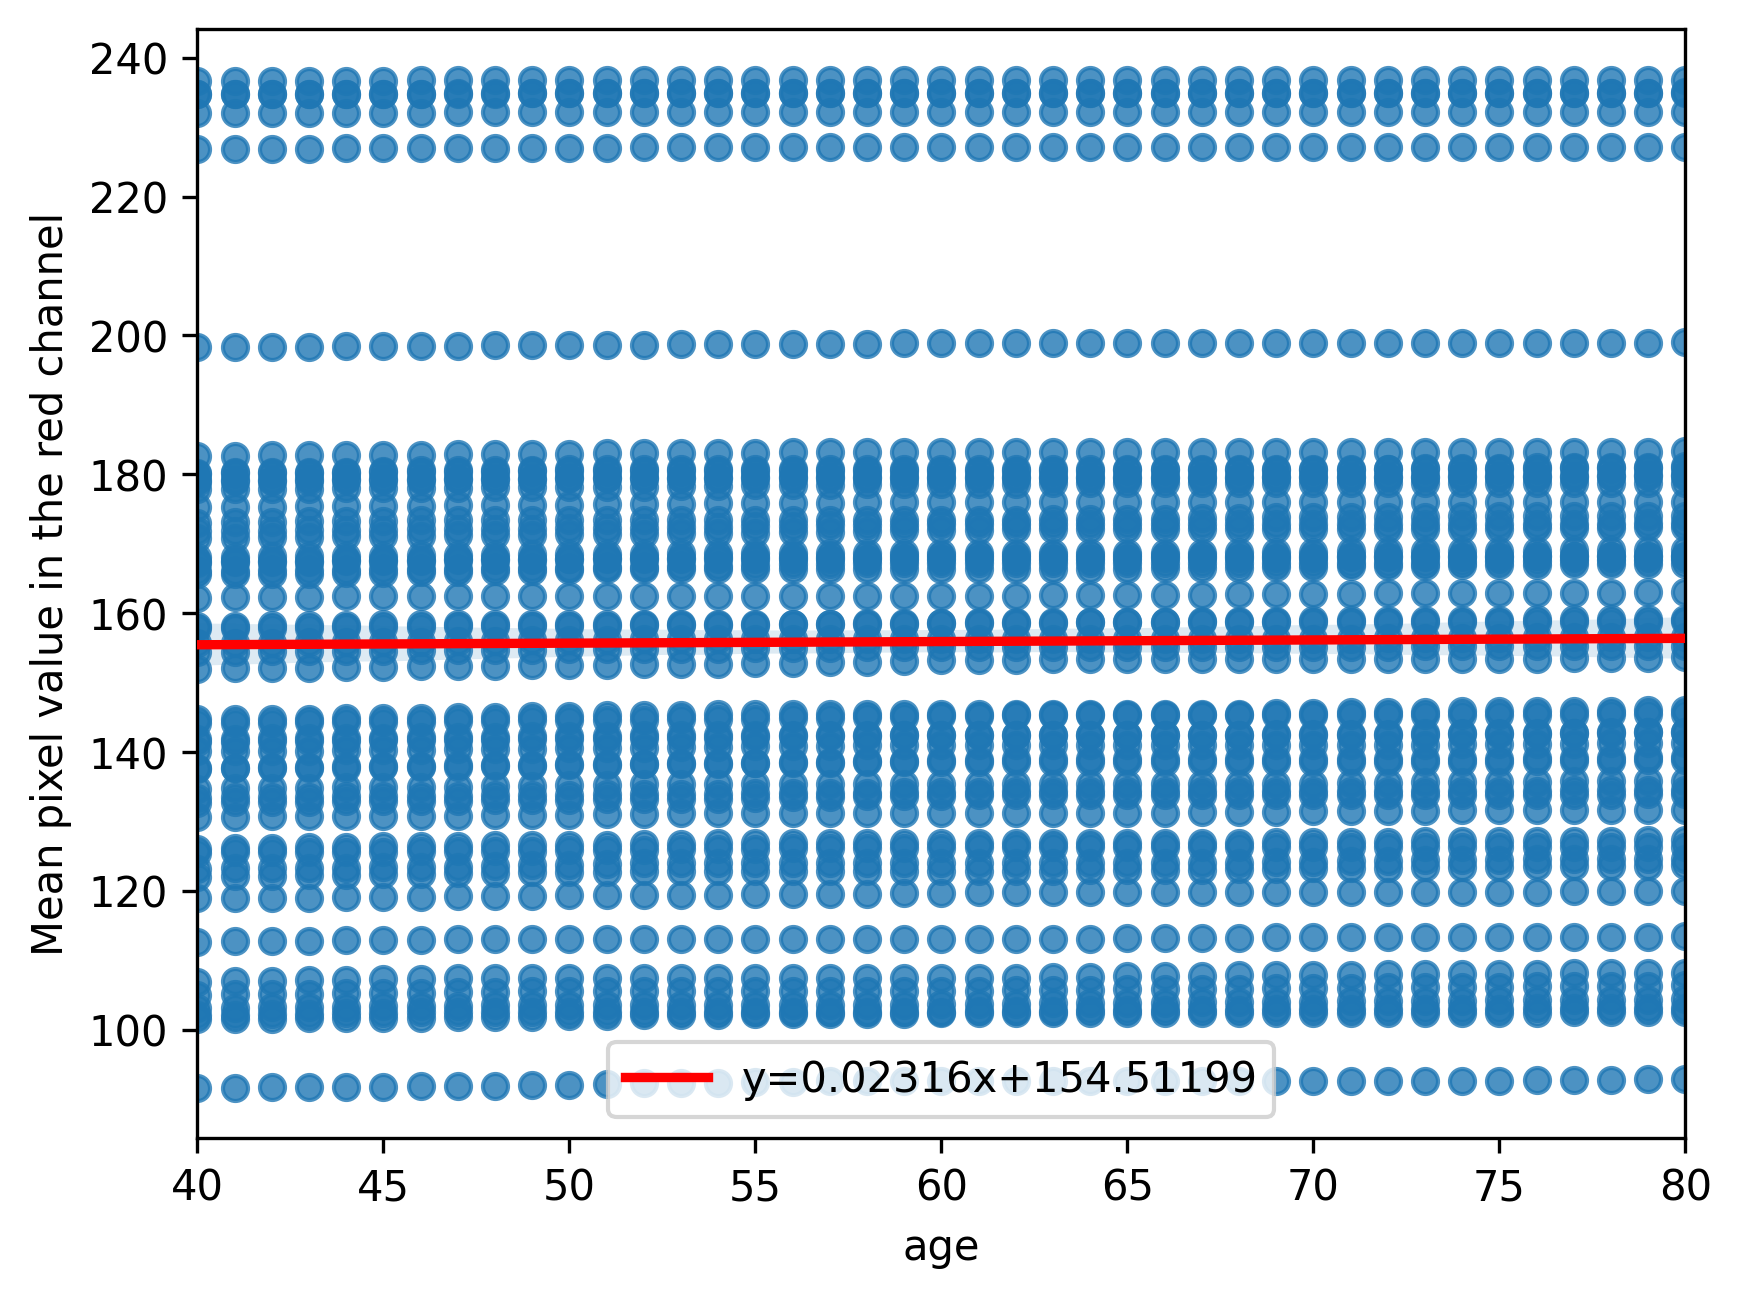

In [83]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test['age'],test['Red_cf'])
g1 = sns.regplot(data = test, x='age', y='Red_cf', line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
g1.set(ylabel='Mean pixel value in the red channel')
regline = g1.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
g1.legend()
plt.savefig("red_cf_age.png")

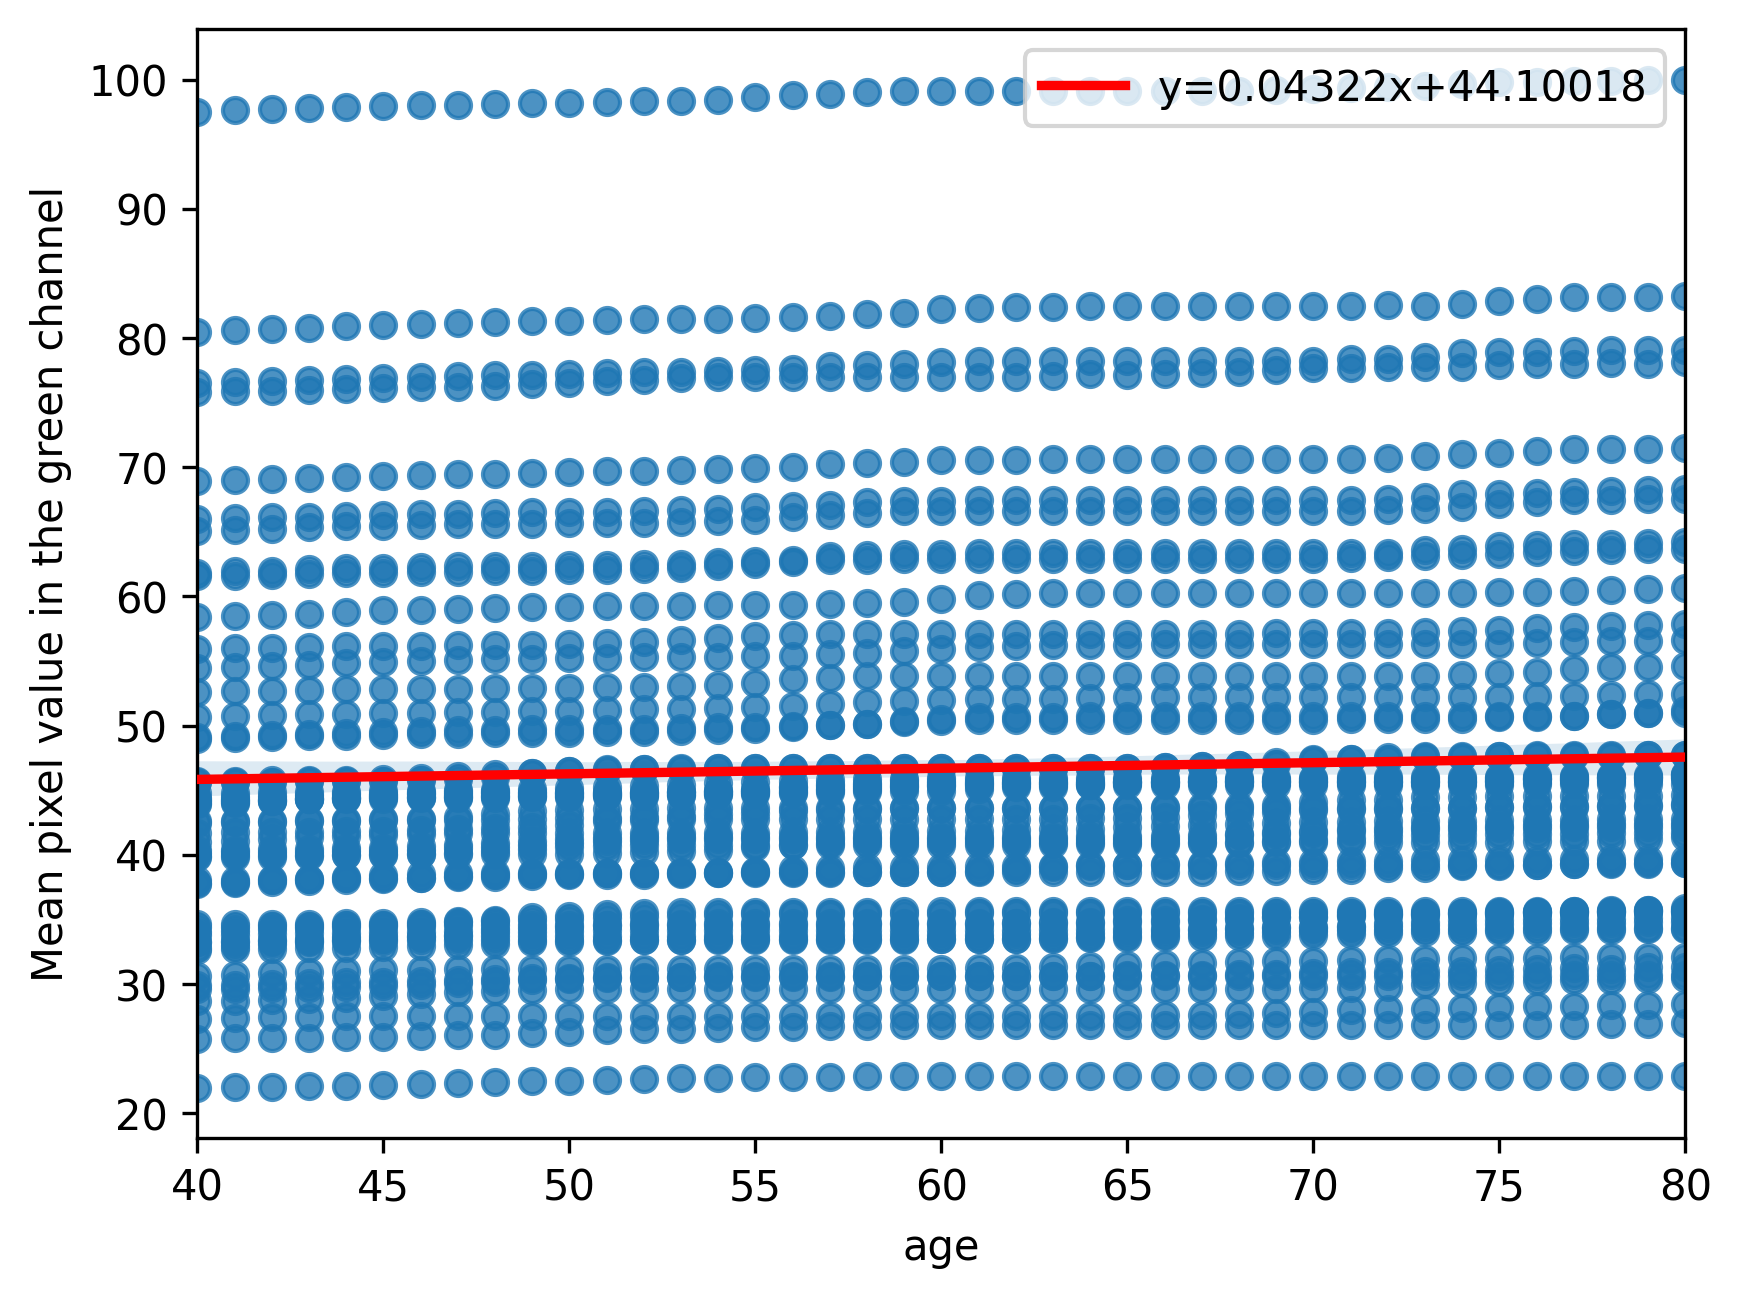

In [84]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test['age'],test['Green_cf'])
g1 = sns.regplot(data = test, x='age', y='Green_cf', line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
g1.set(ylabel='Mean pixel value in the green channel')
regline = g1.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
g1.legend()
plt.savefig("green_cf_age.png")

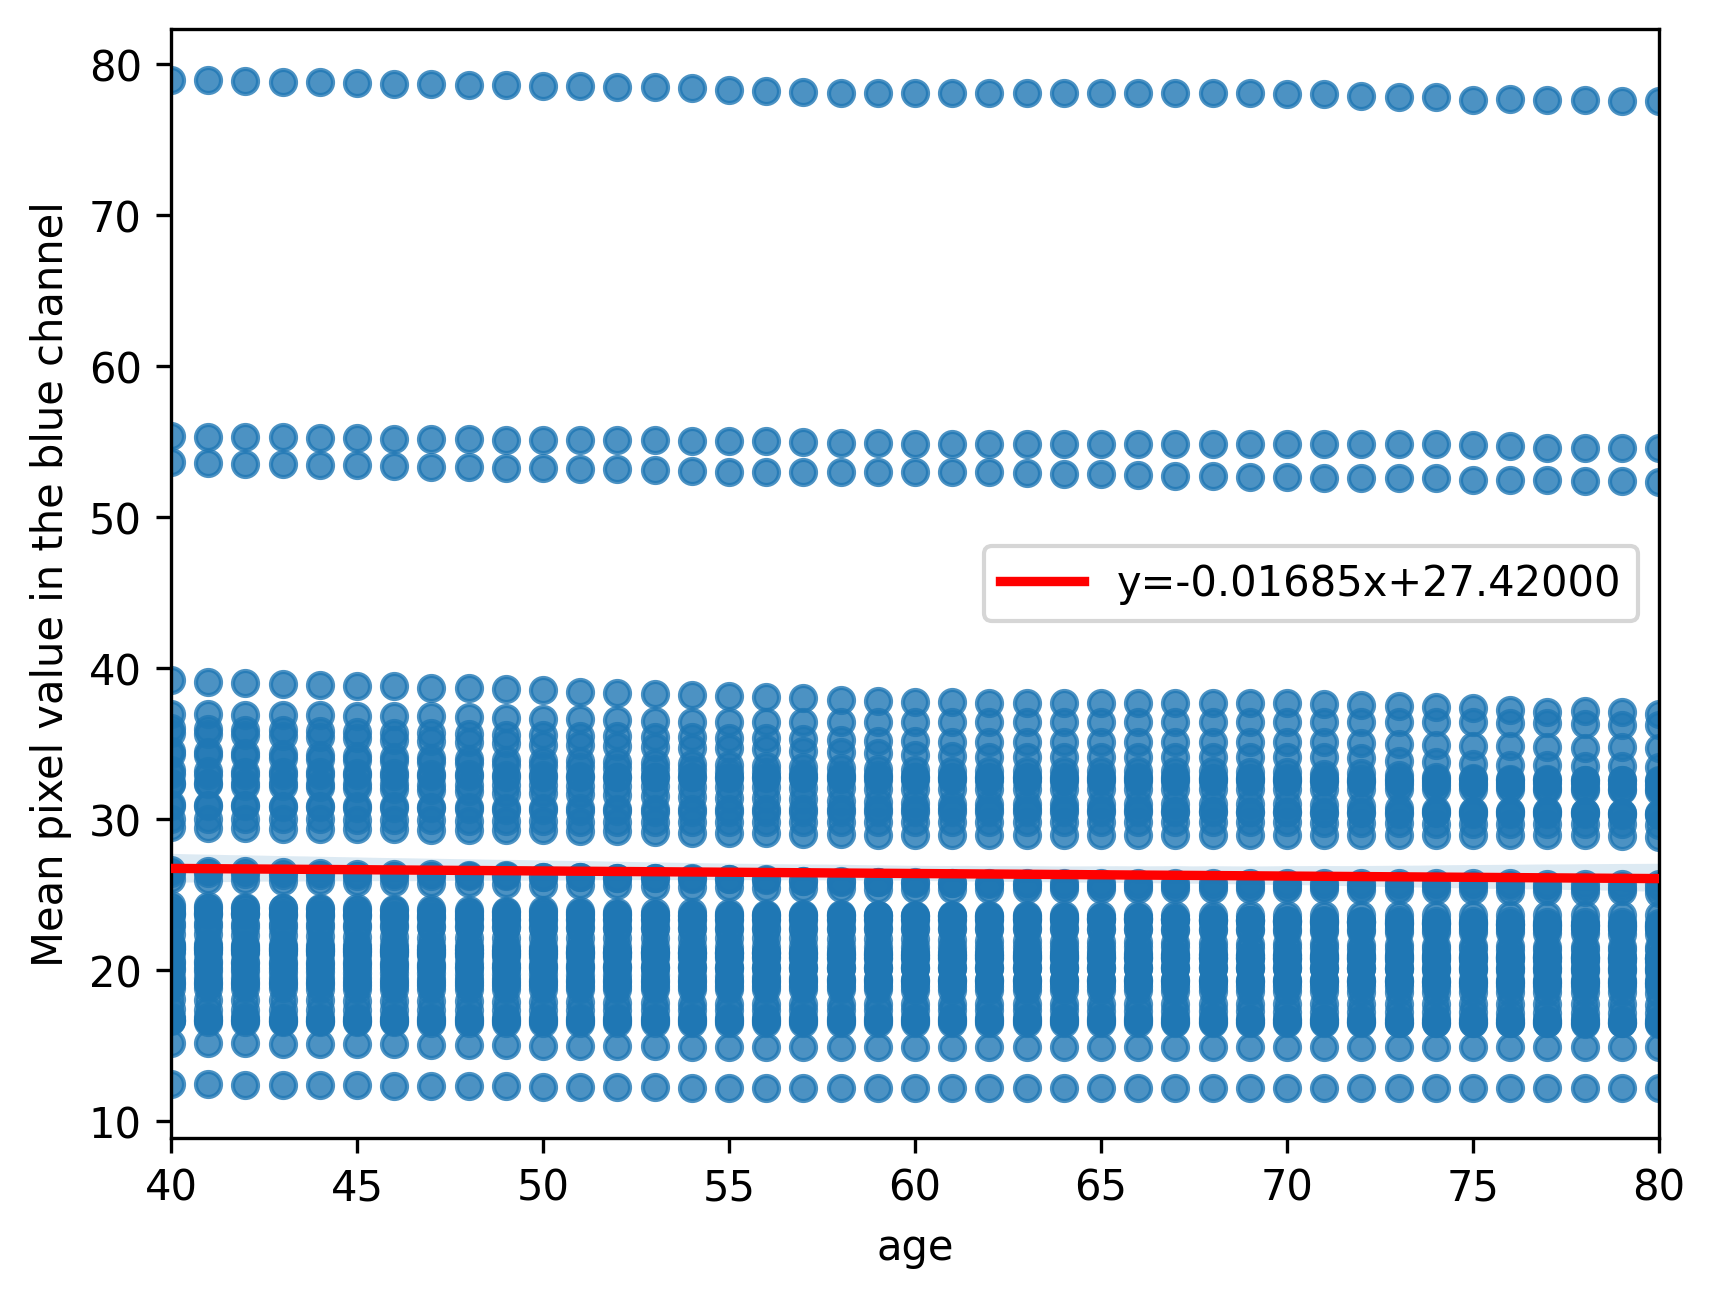

In [85]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test['age'],test['Blue_cf'])
g1 = sns.regplot(data = test, x='age', y='Blue_cf', line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
g1.set(ylabel='Mean pixel value in the blue channel')
regline = g1.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
g1.legend()
plt.savefig("blue_cf_age.png")

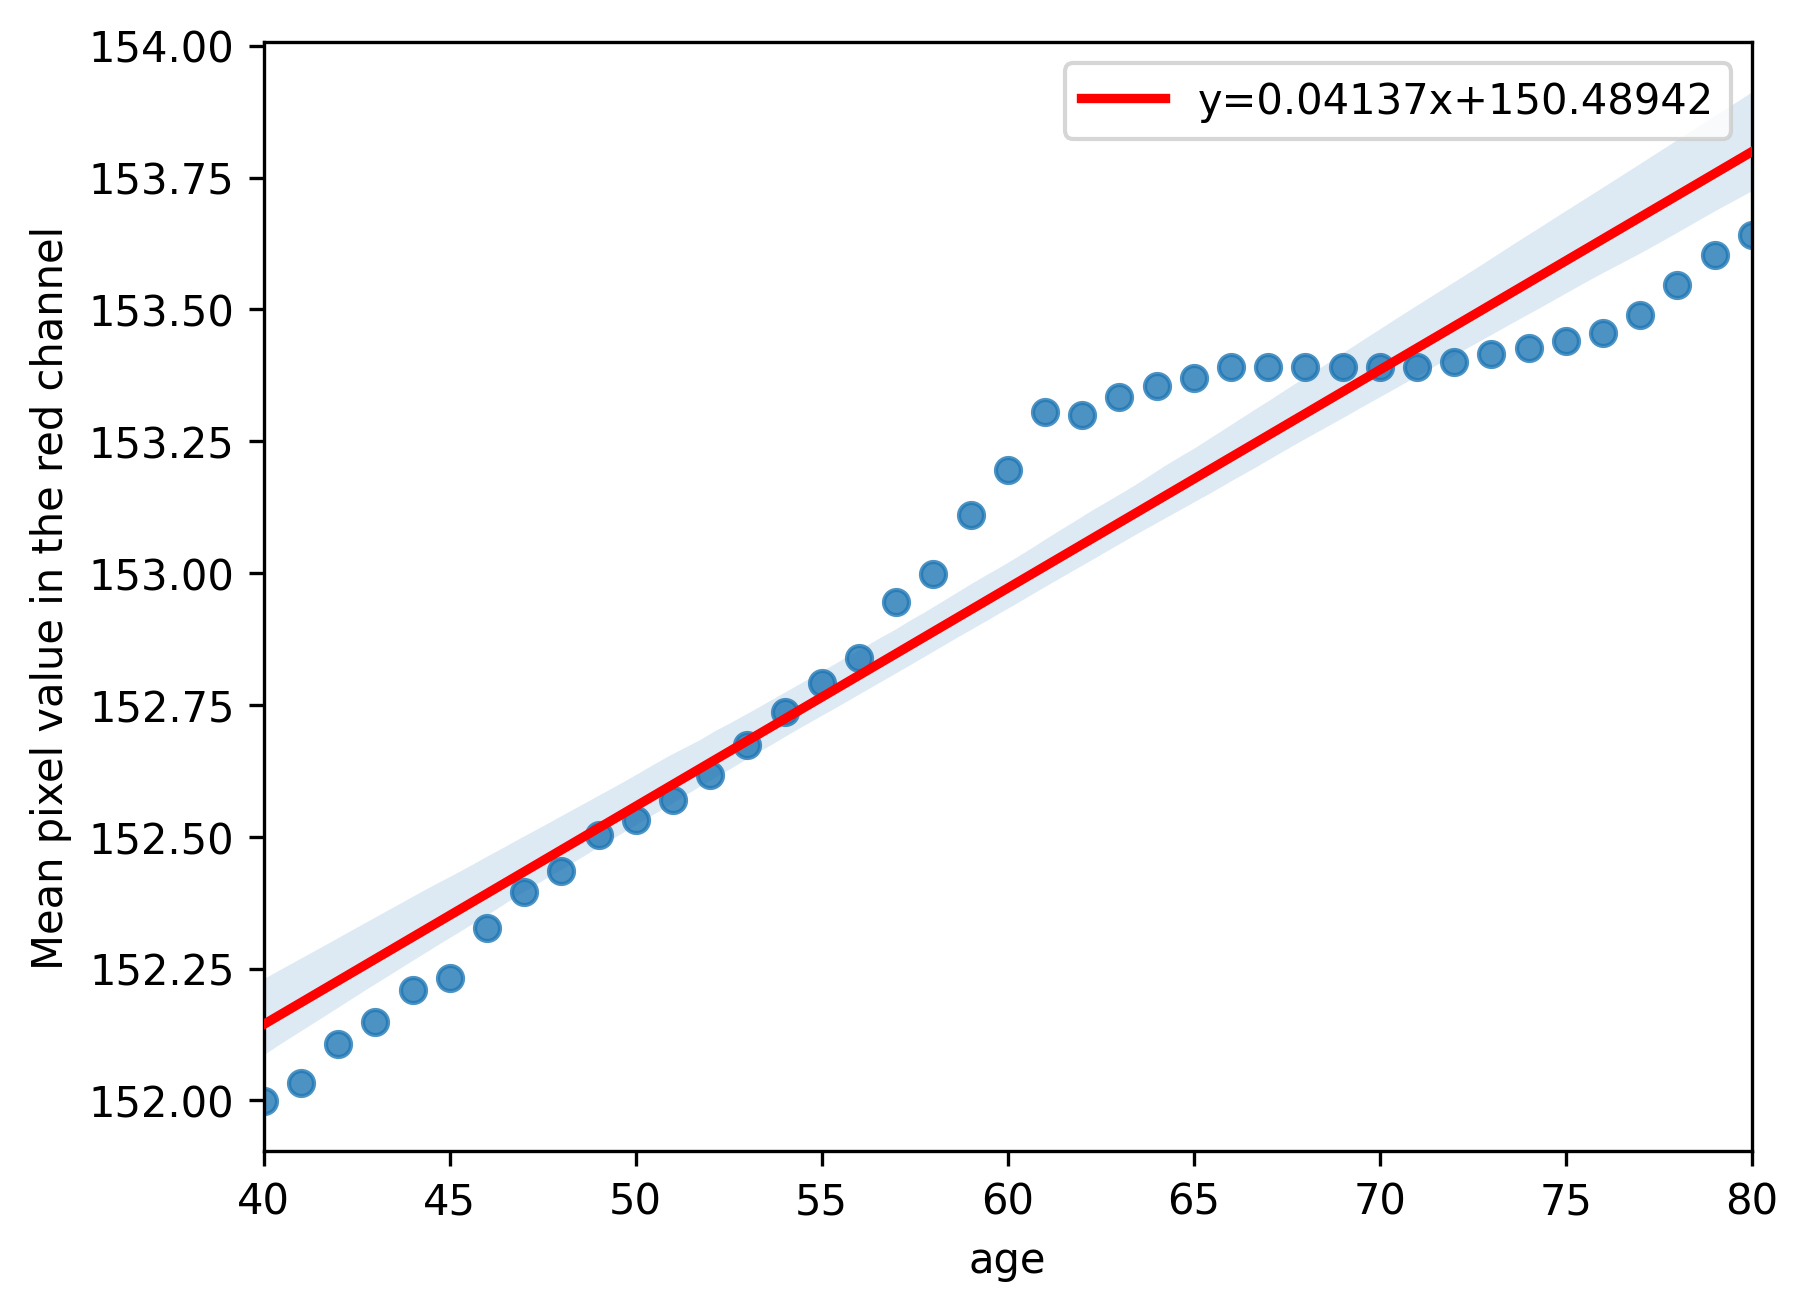

In [86]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test1['age'],test1['Red_cf'])
g1 = sns.regplot(data = test1, x='age', y='Red_cf', line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
g1.set(ylabel='Mean pixel value in the red channel')
regline = g1.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
g1.legend()
plt.savefig("red_cf_age1.png")

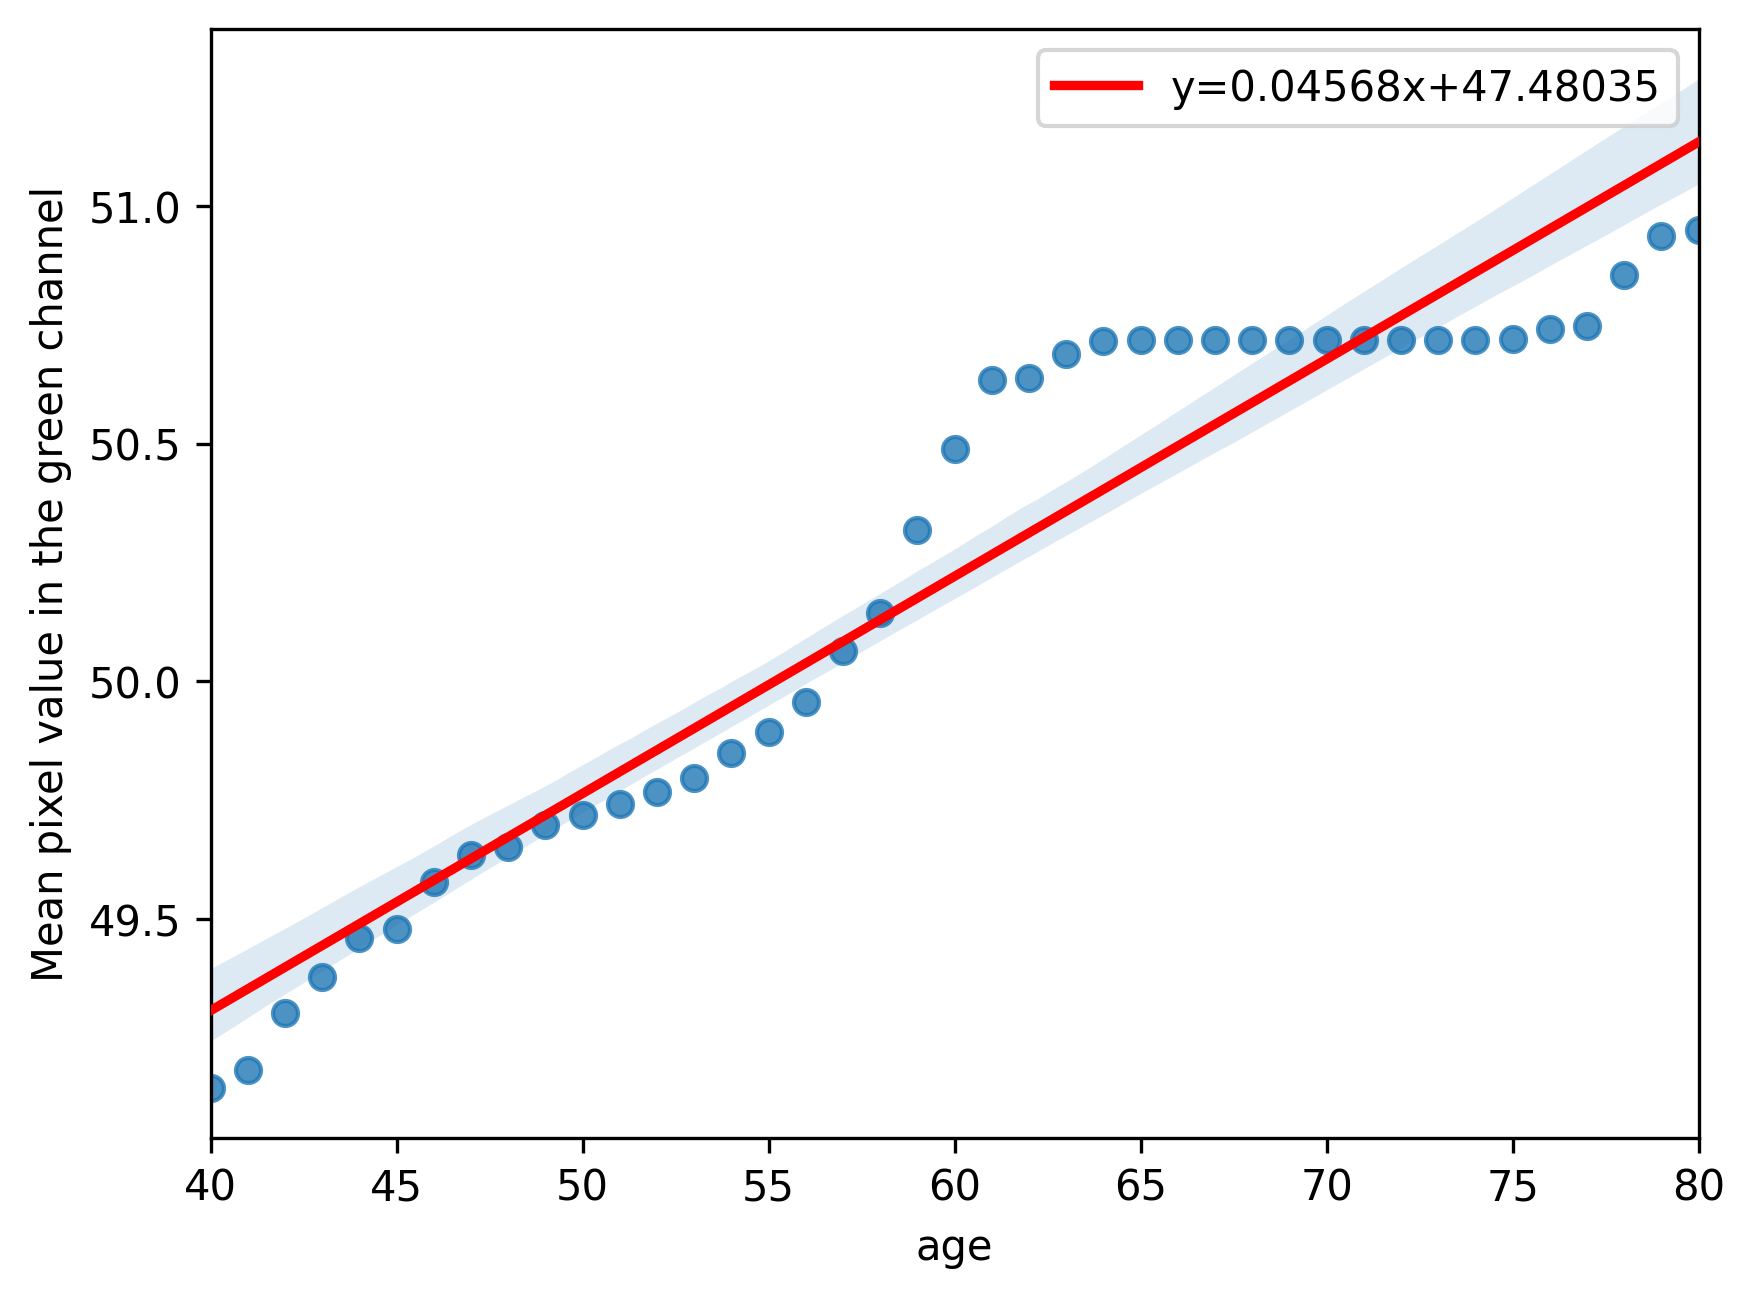

In [87]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test1['age'],test1['Green_cf'])
g1 = sns.regplot(data = test1, x='age', y='Green_cf', line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
g1.set(ylabel='Mean pixel value in the green channel')
regline = g1.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
g1.legend()
g1.set
plt.savefig("green_cf_age1.png")

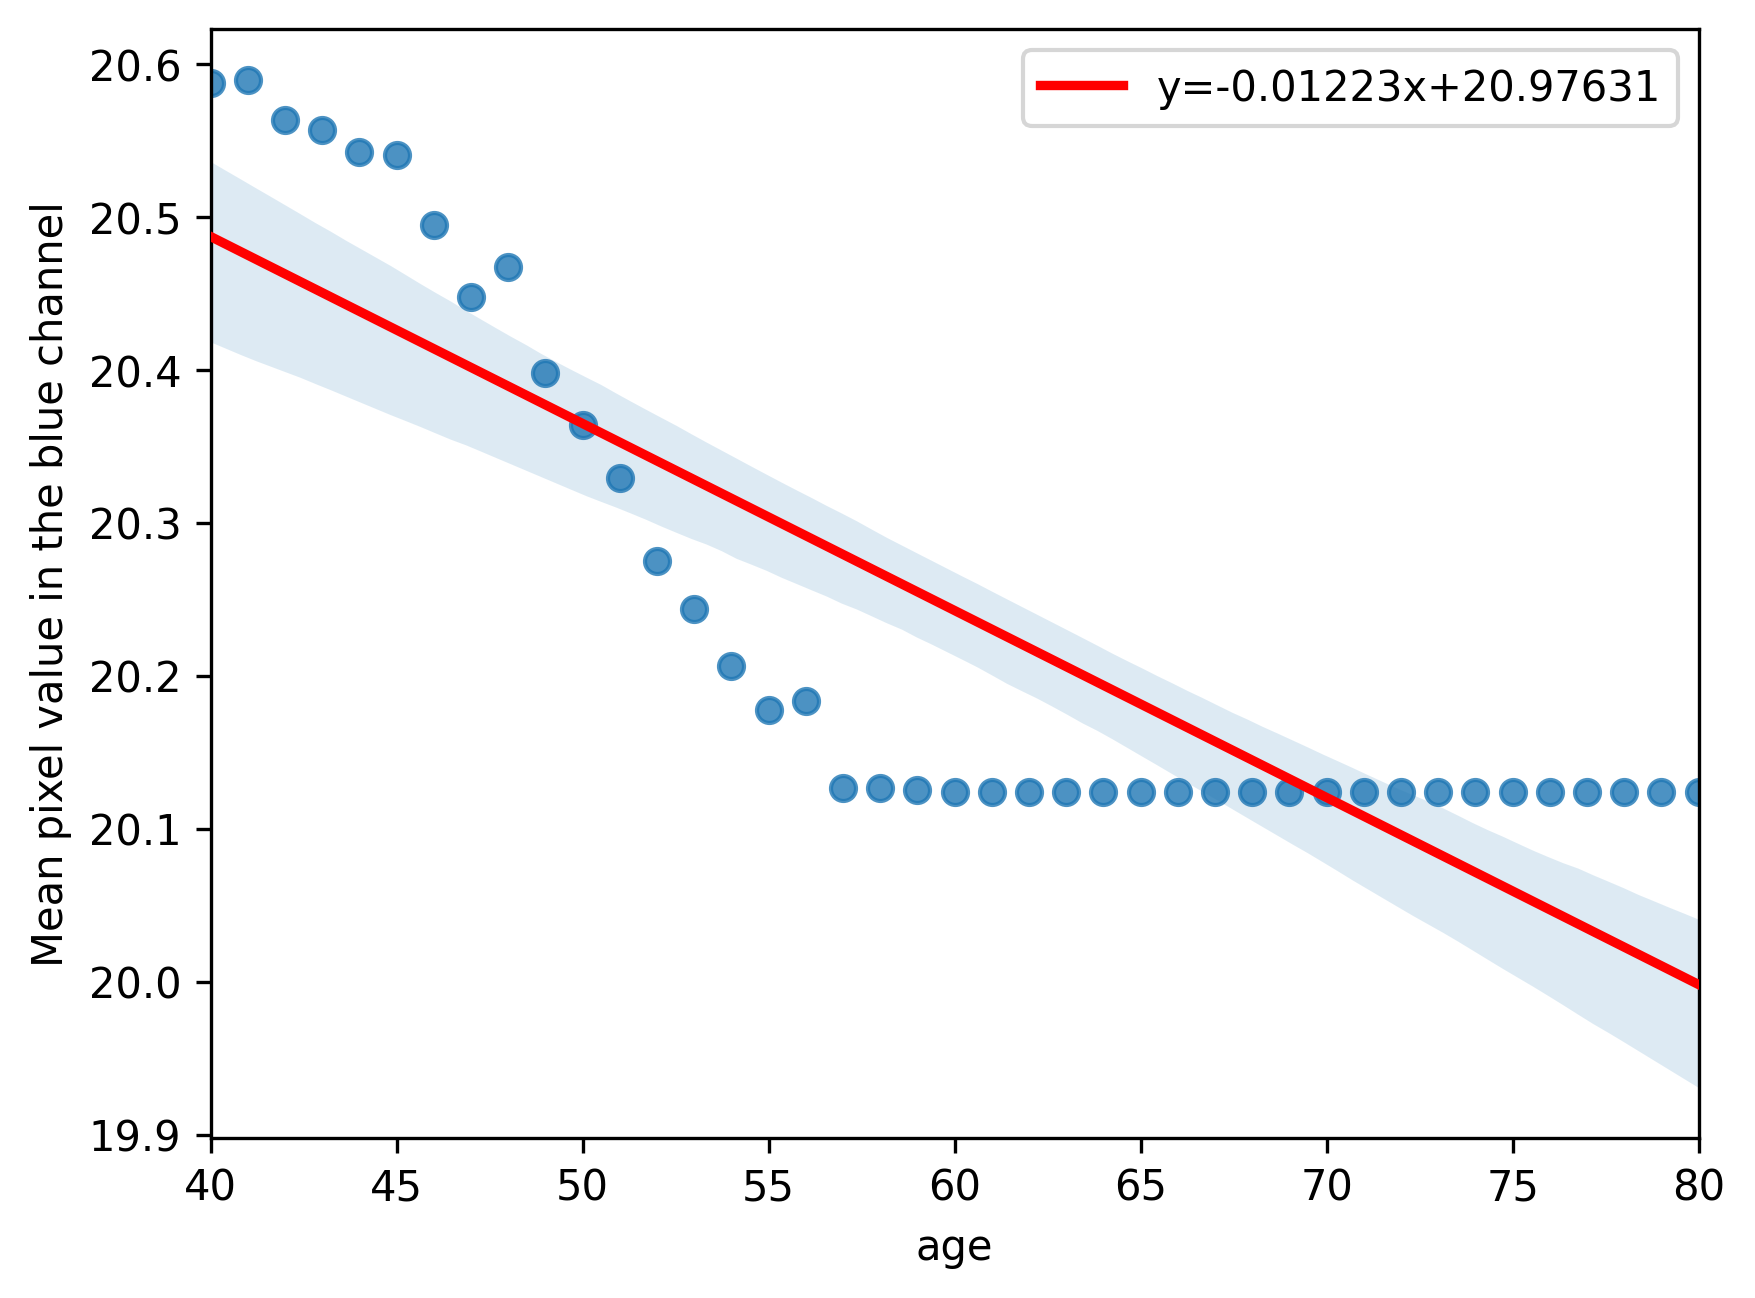

In [88]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test1['age'],test1['Blue_cf'])
g1 = sns.regplot(data = test1, x='age', y='Blue_cf', line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
g1.set(ylabel='Mean pixel value in the blue channel')
regline = g1.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
g1.legend()
plt.savefig("blue_cf_age1.png")